Intro

In [78]:
import numpy as np 
import pandas as pd  
import seaborn as sns 
import matplotlib.pyplot as plt
import mpu
from sklearn.neighbors import LocalOutlierFactor
%matplotlib inline 


In [51]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [52]:
train_df = pd.read_csv(r"C:\Users\arind\OneDrive\Desktop\Kaggle Challenges\train.csv")
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14-03-2016 17:24,14-03-2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12-06-2016 00:43,12-06-2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19-01-2016 11:35,19-01-2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06-04-2016 19:32,06-04-2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26-03-2016 13:30,26-03-2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [53]:
(train_df).isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [54]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.534503e+00,1.664382e+00,-7.397342e+01,4.075094e+01,-7.397336e+01,4.075183e+01,9.621448e+02
std,4.988084e-01,1.314261e+00,4.280165e-02,3.381389e-02,4.274282e-02,3.645002e-02,5.853002e+03
min,1.000000e+00,0.000000e+00,-7.854740e+01,3.435970e+01,-7.981798e+01,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073738e+01,-7.399131e+01,4.073594e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075415e+01,-7.397973e+01,4.075455e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396731e+01,4.076836e+01,-7.396301e+01,4.076984e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.391176e+01,3.526282e+06


Dataset has no missing values

In [55]:
train_df['distance'] = haversine_np(train_df['pickup_longitude'],train_df['pickup_latitude'],
                                    train_df['dropoff_longitude'],train_df['dropoff_latitude']) 

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
id,,,,,,,,,,,,
id2875421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id2377394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id3858529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id3504673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id2181028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
id0002921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id1329189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id0408460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Distance

<AxesSubplot:xlabel='distance'>

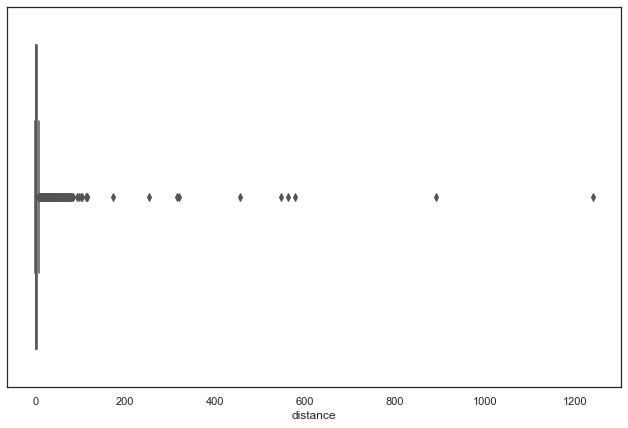

In [91]:
#Distance vs Trip Duration
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.boxplot(data=train_df,x='distance')

<AxesSubplot:xlabel='distance', ylabel='trip_duration'>

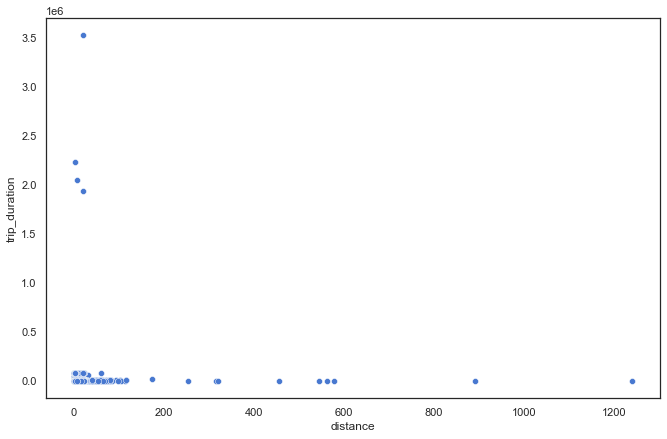

In [64]:
#Distance vs Trip Duration
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.scatterplot(data=train_df,x='distance',y='trip_duration')

In [75]:
train_df['distance'].std()

4.379227571559008